In [1]:
import os
import os.path as osp
import sys
import numpy as np
from pprint import pprint

# add matplotlib before cv2, otherwise bug
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 10.0)

# add  
sys.path.insert(0, '../lib')
from roi_data_layer.layer import RoIDataLayer
from datasets import refer_loader
from layer_utils.mask_target_layer import mask_target_layer
from utils.mask_utils import decode
from model.config import cfg
cfg.TRAIN.BATCH_SIZE = 12
cfg.TRAIN.BBOX_NORMALIZE_TARGETS_PRECOMPUTED = True

# torch
import torch
from torch.autograd import Variable

In [30]:
# visualize
def vis_pos(loader, im_data, labels, boxes, masks=None):
    PIXEL_MEANS = np.array([[[102.9801, 115.9465, 122.7717]]])
    im_data += PIXEL_MEANS
    im_data[:,:,:] = im_data[:,:,[2,1,0]]
    im_data = im_data.astype(np.uint8)
    plt.imshow(im_data)
    num_anns = labels.shape[0]
    NPs = loader.decode_labels(labels)
    ax = plt.gca()
    for ix in range(num_anns):
        if masks is not None:
            # add mask
            m = masks[ix]/255.  # float32 ranging [0,1]
            color_mask = np.random.random((1,3)).tolist()[0]
            img = np.ones( (m.shape[0], m.shape[1], 3) )
            for i in range(3):
                img[:, :, i] = color_mask[i]
            ax.imshow(np.dstack( (img, m*0.2) ))
        # add box and label
        box = boxes[ix] # uint8 (x1y1x2y2)
        x1 = int(round(box[0]))
        y1 = int(round(box[1]))
        x2  = int(round(box[2]))
        y2  = int(round(box[3]))
        display_txt = NPs[ix]
        coords = (x1, y1), x2-x1+1, y2-y1+1
        ax.add_patch(plt.Rectangle(*coords, fill=False, edgecolor='green', linewidth=2))
        ax.text(x1, y1, display_txt, bbox={'facecolor':'green', 'alpha':0.5})
    return ax

def vis_neg(loader, im_data, labels, boxes):
    PIXEL_MEANS = np.array([[[102.9801, 115.9465, 122.7717]]])
    im_data += PIXEL_MEANS
    im_data[:,:,:] = im_data[:,:,[2,1,0]]
    im_data = im_data.astype(np.uint8)
    plt.imshow(im_data)
    num_anns = labels.shape[0]
    NPs = loader.decodeNPs(labels)
    ax = plt.gca()
    for ix in range(num_anns):
        # add box and label
        box = boxes[ix] # uint8 (x1y1x2y2)
        x1 = int(round(box[0]))
        y1 = int(round(box[1]))
        x2  = int(round(box[2]))
        y2  = int(round(box[3]))
        display_txt = NPs[ix]
        coords = (x1, y1), x2-x1+1, y2-y1+1
        ax.add_patch(plt.Rectangle(*coords, fill=False, edgecolor='red', linewidth=2))
        ax.text(x1, y1, display_txt, bbox={'facecolor':'red', 'alpha':0.5})

In [3]:
# refer loader
loader = refer_loader.loader(dataset='refcoco', splitBy='unc')
# append flipped
print('Appending horizontally-flipped training examples...')
loader.append_flipped_images('train')
print('done')

info read from /mnt/ilcompf6d0/user/liyu/Documents/work/refer_adobe/faster-rcnn/find-mask-rcnn/data/cache/refcoco_unc/data.json in 6.77 seconds.
vocab size is  1999
We have 19994 images, 196771 anns, 50000 refs.
object category size is  81
We have 299048 NPs (max_NP_length=5) for 196771 anns.
We have 290168 NNs (max_NN_length=3) for 196771 anns.
assigned 750 images to split testA.
assigned 16994 images to split train.
assigned 1500 images to split val.
assigned 750 images to split testB.
gt_roidb loaded from /mnt/ilcompf6d0/user/liyu/Documents/work/refer_adobe/faster-rcnn/find-mask-rcnn/data/cache/refcoco_unc/gt_roidb.pkl in 3.49 seconds
Appending horizontally-flipped training examples...
done


In [4]:
# Layer
data_layer = RoIDataLayer(loader, ['train', 'val'], 'NN')

In [32]:
# get one batch
blobs = data_layer.forward()
print(blobs.keys())
print(blobs['gt_boxes'].shape)

['neg_labels', 'im_info', 'gt_labels', 'num_labels', 'bg_labels', 'gt_boxes', 'data', 'gt_masks']
(12, 5)


In [39]:
# Fake some inputs
num_rpn_rois = min(3, blobs['gt_boxes'].shape[0])
rpn_rois = np.hstack([np.zeros((num_rpn_rois, 1)),
                      blobs['gt_boxes'][:num_rpn_rois, :4]]).astype(np.float32) # float (N, 5) [0xyxy]
rpn_rois = np.vstack([rpn_rois, np.array([0, 200, 200, 300, 300], dtype=np.float32)])

gt_boxes = blobs['gt_boxes']   # (M, 5) [xyxycls]
gt_labels = blobs['gt_labels'] # (M, L)
neg_labels = blobs['neg_labels'] # (M, 80, L)
bg_labels = blobs['bg_labels'] # (81, L)
gt_masks = blobs['gt_masks']# uint8 [0, 1]

In [40]:
# move to gpu Variable
rpn_rois = Variable(torch.from_numpy(rpn_rois).cuda())
gt_boxes = Variable(torch.from_numpy(gt_boxes).float().cuda())
gt_labels = Variable(torch.from_numpy(gt_labels).cuda())
neg_labels = Variable(torch.from_numpy(neg_labels).cuda())
bg_labels = Variable(torch.from_numpy(bg_labels).cuda())

In [41]:
# run mask_target_layer
rois, labels, bbox_targets, bbox_inside_weights, bbox_outside_weights, mask_targets = \
mask_target_layer(rpn_rois, gt_boxes, gt_labels, neg_labels, bg_labels, gt_masks)

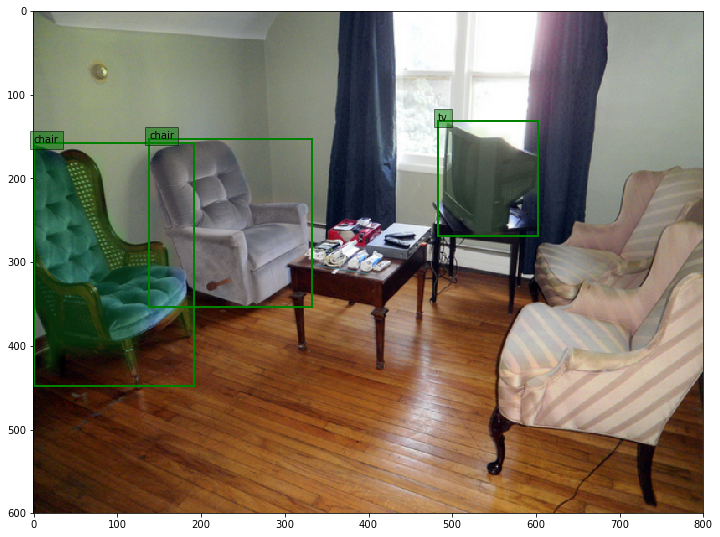

In [42]:
# show rois
plt.figure()
num_pos_rois = mask_targets.size(0)
pos_bbox_pred = rois.data.cpu().numpy()[:num_pos_rois, 1:5]
imh, imw = int(blobs['im_info'][0][0]), int(blobs['im_info'][0][1])
mask = decode(mask_targets.data.cpu().numpy(), pos_bbox_pred, imh, imw, 'bilinear')
pos_texts = labels.data.cpu().numpy()[:num_pos_rois, 0, :]
vis_pos(loader, blobs['data'][0].copy(), pos_texts, pos_bbox_pred, mask)
plt.show()

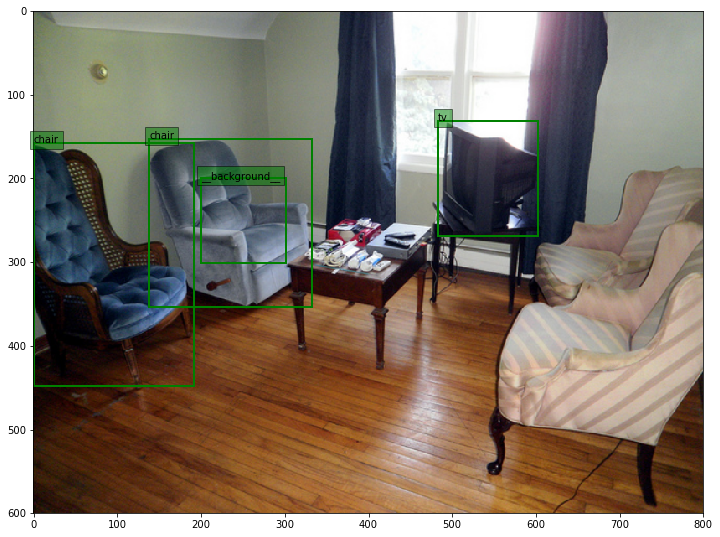

In [44]:
plt.figure()
num_rpn_rois = rpn_rois.size(0)
bbox_pred = rois.data.cpu().numpy()[:num_rpn_rois, 1:5]
imh, imw = int(blobs['im_info'][0][0]), int(blobs['im_info'][0][1])
texts = labels.data.cpu().numpy()[:num_rpn_rois, 0, :]
vis_pos(loader, blobs['data'][0].copy(), texts, bbox_pred, None)
plt.show()

In [46]:
print(loader.decode_labels(labels.data.cpu().numpy()[2, 0:1, :]))
print(loader.decode_labels(labels.data.cpu().numpy()[2, 1:81, :]))

[u'chair']
[u'toliet', u'teddybear', u'mug', u'bike seat', u'parachute', u'carrot', u'stop sign', u'tennis racket', u'glazed donut', u'__background__', u'taco', u'motorcycle', u'oven door', u'keys', u'scissors', u'airplane tail', u'chair', u'mouse', u'fire hydrant', u'ship', u'apple slice', u'goat', u'horse', u'banana', u'baseball glove', u'monitor', u'traffic', u'rice', u'oven', u'bench', u'<UNK>', u'baby elephant', u'lemon', u'tie', u'clock', u'swan', u'knife', u'pepperoni pizza', u'fork', u'hair drier', u'frisbee', u'rainbow umbrella', u'oil', u'double decker', u'bear', u'vase', u'toothbrush', u'spoon', u'and train', u'dishes', u'palm tree', u'handbag', u'iphone', u'toaster', u'brocolli', u'fridge', u'macbook', u'wii', u'surfboard', u'cow face', u'table', u'sausage', u'police car', u'board', u'sports ball', u'skateboard', u'puppy', u'bunk', u'kitty', u'standing woman', u'skis', u'giraffe neck', u'ambulance', u'meter', u'suit case', u'chocolate cake', u'wineglass', u'baseball bat', u

In [12]:
# pprint(data_layer._class_to_synonyms)